In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as oj
import math
import pygsheets
import pickle as pkl
import pandas as pd
import load_data
import seaborn as sns
sys.path.append('modeling')
from viz import viz, viz_interactive
from exponential_modeling import estimate_deaths
from fit_and_predict import add_preds

outcomes = ['tot_cases', 'tot_deaths']
df_hospital = load_data.load_hospital_level()
df_county = load_data.load_county_level()
df_county = df_county.sort_values('tot_deaths', ascending=False)
df_county = add_preds(df_county, NUM_DAYS_LIST=[1, 2, 3]) # adds keys like "Predicted Deaths 1-day"

df = df_hospital.merge(df_county, how='left', on='countyFIPS')
df[outcomes] = df[outcomes].fillna(0)

# aggregate employees by county
total_emp_county = df.groupby('countyFIPS').agg({'Hospital Employees': 'sum'})
total_emp_county = total_emp_county.rename(columns={'Hospital Employees': 'Hospital Employees in County'})
df_county = pd.merge(df_county, total_emp_county, how='left', on='countyFIPS')
df = pd.merge(df, total_emp_county, how='left', on='countyFIPS')

# filter hospitals
df = df[~df['countyFIPS'].isna()] # & df['IsAcademicHospital'] & df['Hospital Employees'] > 0]
df = df.sort_values(by=['tot_deaths', 'Hospital Employees'], ascending=False)


# fraction of employees out of all county hospitals
df['Frac Hospital Employees of County'] = df['Hospital Employees'] / df['Hospital Employees in County']

In [7]:
# this is number of new predicted deaths
for num_days in NUM_DAYS_LIST:
    df[f'Predicted Deaths Hospital {num_days}-day'] = ((df[f'Predicted Deaths {num_days}-day'] - df['tot_deaths']) * df['Frac Hospital Employees of County']).fillna(0)
    df[f'Severity {num_days}-day'] = pd.qcut(df[f'Predicted Deaths Hospital {num_days}-day'], 5, labels=False) + 1
#     df[f'Quantile {num_days}-day'] = 
k = 2
s_hosp = f'Predicted Deaths Hospital {k}-day'
df = df.sort_values(s_hosp, ascending=False).round(2)

In [13]:
df.head(5)

,Unnamed: 0,CMS Certification Number,Facility Name,Street Address_x,City_x,State_x,ZIP,System Affiliation,Type of Facility,Hospital Employees,...,Predicted Deaths 2-day,Predicted Deaths 3-day,Hospital Employees in County,Frac Hospital Employees of County,Predicted Deaths Hospital 1-day,Severity 1-day,Predicted Deaths Hospital 2-day,Severity 2-day,Predicted Deaths Hospital 3-day,Severity 3-day
3736,3736,330059,Montefiore Hospital- Moses Campus,111 East 210th Street,Bronx,NY,10467,"Montefiore Health System - Bronx, NY",Short Term Acute Care,18142.0,...,375.10,447.58,35475.0,0.51,26.43,5,57.84,5,94.91,5
3732,3732,330055,NewYork-Presbyterian Queens Hospital,56-45 Main Street,Flushing,NY,11355,New York-Presbyterian Healthcare System - New ...,Short Term Acute Care,3795.0,...,546.48,657.60,18400.0,0.21,15.90,5,35.16,5,58.08,5
3717,3717,330014,Jamaica Hospital Medical Center,8900 Vanwyck Expressway,Jamaica,NY,11418,"Not In Any System - ,",Short Term Acute Care,3095.0,...,546.48,657.60,18400.0,0.17,12.97,5,28.68,5,47.37,5
3773,3773,330128,NYC Health + Hospitals Elmhurst,79-01 Broadway,Elmhurst,NY,11373,"NYC Health + Hospitals - New York, NY",Short Term Acute Care,3001.0,...,546.48,657.60,18400.0,0.16,12.58,5,27.81,5,45.93,5
2735,2735,230053,Henry Ford Hospital,2799 West Grand Boulevard,Detroit,MI,48202,"Henry Ford Health System - Detroit, MI",Short Term Acute Care,11178.0,...,194.11,248.76,38577.0,0.29,9.26,5,21.48,5,37.31,5


**look at distribution of predicted deaths at hospitals**

In [ ]:
R, C  = 1, 1
num_days = 1
nonzero = df[s_hosp] > 0
plt.figure(dpi=300, figsize=(7, 3))
plt.subplot(R, C, 1)

plt.plot(df[s_hosp].values, '.-')
plt.ylabel(s_hosp)
plt.xlabel('Hospitals')

plt.tight_layout()
plt.show()

In [ ]:
df.sort_values('Predicted Deaths Hospital 2-day', ascending=False)[['Hospital Name', 'State_x', 
                                                                    'Hospital Employees', 'tot_deaths',
                                                                    'Predicted Deaths Hospital 2-day']].head(30)

# adjustments

**different measures of hospital size are pretty consistent**

In [ ]:
plt.figure(dpi=500, figsize=(7, 3))
R, C = 1, 3
plt.subplot(R, C, 1)
plt.plot(df['Hospital Employees'], df['Total Average Daily Census'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('Total Average Daily Census')

plt.subplot(R, C, 2)
plt.plot(df['Hospital Employees'], df['Total Beds'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('Total Beds')

plt.subplot(R, C, 3)
plt.plot(df['Hospital Employees'], df['ICU Beds'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('ICU Beds')

plt.tight_layout()
plt.show()

**other measures are harder to parse...**

In [ ]:
plt.figure(dpi=300, figsize=(4, 3))
R, C = 1, 1
s = s_hosp
plt.subplot(R, C, 1)
plt.plot(df[s], df['Total Occupancy Rate'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel(s)
plt.ylabel('ICU Occupancy Rate')

'''
plt.subplot(R, C, 2)
# plt.plot(df['Hospital Employees'], df[], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('ICU Occupancy Rate')
'''

plt.tight_layout()
plt.show()

**different hospital types**

In [ ]:
plt.figure(dpi=500, figsize=(7, 3))
R, C = 1, 3
a = 0.5
s = s_hosp
plt.subplot(R, C, 1)
idxs = df.IsUrbanHospital == 1
plt.hist(df[idxs][s], label='Urban', alpha=a)
plt.hist(df[~idxs][s], label='Rural', alpha=a)
plt.ylabel('Num Hospitals')
plt.xlabel(s)
plt.yscale('log')
plt.legend()

plt.subplot(R, C, 2)
idxs = df.IsAcuteCareHospital == 1
plt.hist(df[idxs][s], label='Acute Care', alpha=a)
plt.hist(df[~idxs][s], label='Other', alpha=a)
plt.xlabel(s)
plt.yscale('log')
plt.legend()

plt.subplot(R, C, 3)
idxs = df.IsAcademicHospital == 1
plt.hist(df[idxs][s], label='Academic', alpha=a)
plt.hist(df[~idxs][s], label='Other', alpha=a)
plt.xlabel(s)
plt.yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

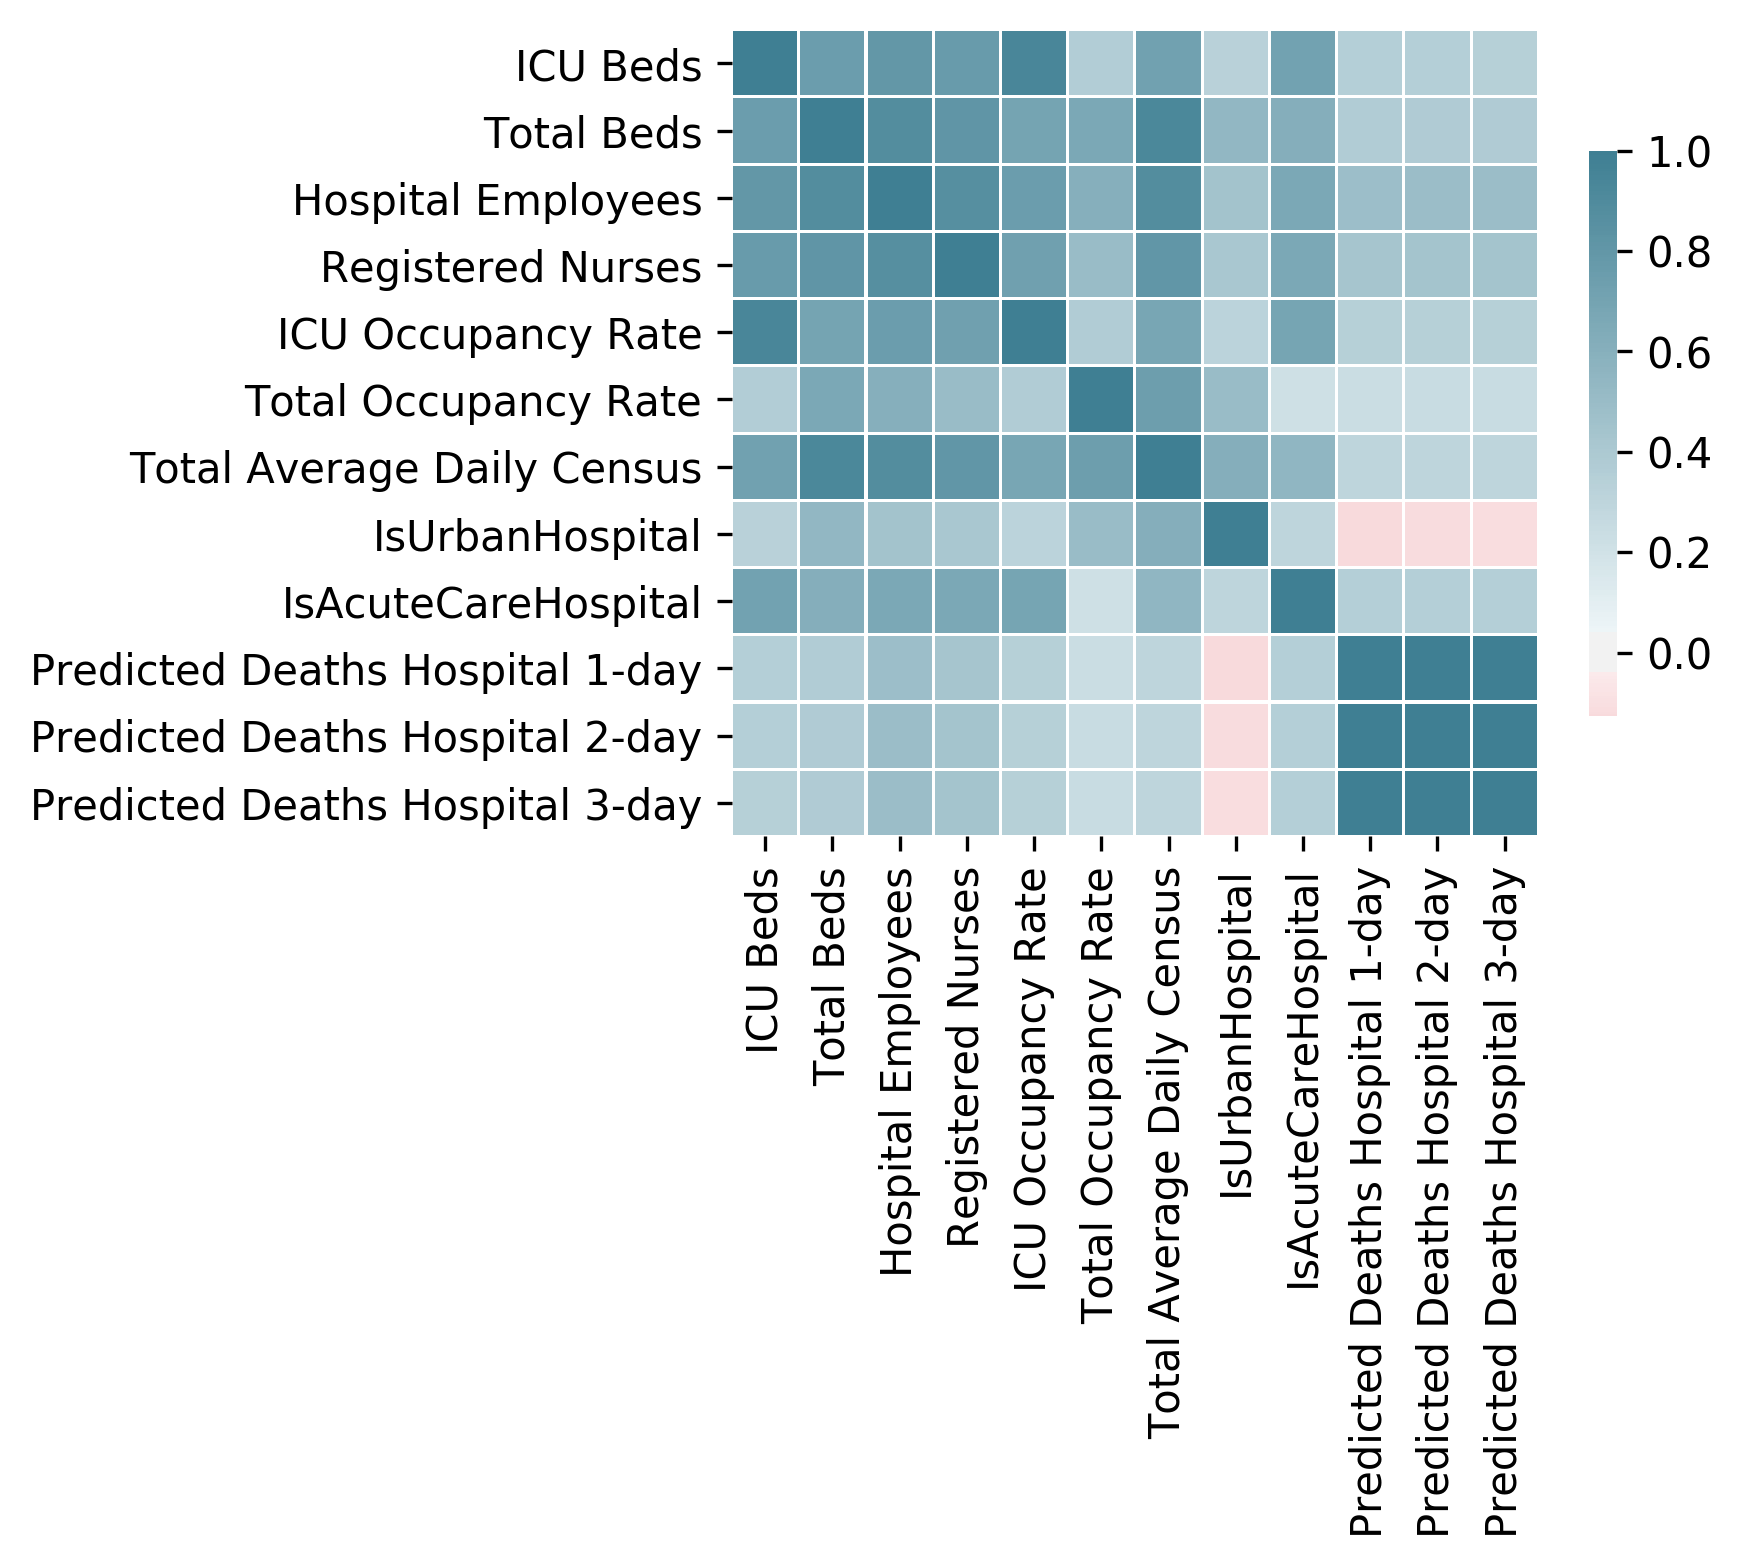

In [4]:
ks = ['ICU Beds', 'Total Beds', 
      'Hospital Employees', 'Registered Nurses',
      'ICU Occupancy Rate', 'Total Occupancy Rate',
      'Mortality national comparison', 'Total Average Daily Census',
      
#       'IsAcademicHospital', 
      'IsUrbanHospital',
      'IsAcuteCareHospital']
      
      

# ks += [f'Predicted Deaths {n}-day' for n in NUM_DAYS_LIST]
ks += [f'Predicted Deaths Hospital {n}-day' for n in NUM_DAYS_LIST]

# county-level stuff
# ks += ['unacast_n_grade', Hospital Employees in County', 'tot_deaths', 'tot_cases', 'PopulationDensityperSqMile2010'] 


viz.corrplot(df[ks], SIZE=6)

**hospitals per county**

In [ ]:
d = df

R, C = 1, 2
NUM_COUNTIES = 7
plt.figure(dpi=300, figsize=(7, 3.5))


plt.subplot(R, C, 1)
c = 'County Name'
county_names = d[c].unique()[:NUM_COUNTIES]
num_academic_hospitals = []
# d = df[outcome_keys + hospital_keys]
# d = d.sort_values('New Deaths', ascending=False)
for county in county_names:
    num_academic_hospitals.append(d[d[c] == county].shape[0])
plt.barh(county_names[::-1], num_academic_hospitals[::-1]) # reverse to plot top down
plt.xlabel('Number academic hospitals\n(for hospitals where we have data)')

plt.subplot(R, C, 2)
plt.barh(df_county.CountyName[:NUM_COUNTIES].values[::-1], df_county['Hospital Employees in County'][:NUM_COUNTIES][::-1]) # reverse to plot top down
plt.xlabel('# Hospital Employees')

plt.tight_layout()
plt.show()

# look at top counties

In [ ]:
county_names = d[c].unique()[:NUM_COUNTIES]
R, C = 4, 1
plt.figure(figsize=(C * 3, R * 3), dpi=200)
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    cn = county_names[i]
    dc = d[d[c] == cn]
    plt.barh(dc['Hospital Name'][::-1], dc['Hospital Employees'][::-1])
    plt.title(cn)
    plt.xlabel('# Hospital Employees')
plt.tight_layout()
# plt.subplots_adjust(bottom=1)
plt.show()

# write to excel sheets

In [52]:
ks_output = ['Severity 1-day', 'Severity 2-day', 'Severity 3-day'] + \
            ['Hospital Name'] + ['CMS Certification Number', 'countyFIPS']

In [53]:
gc = pygsheets.authorize(service_file='creds.json')

#open the google spreadsheet (where 'PY to Gsheet Test' is the name of my sheet)
sheet_name = 'COVID Pandemic Severity Index'
sh = gc.open(sheet_name) # name of the hospital

# ventilator
wks = sh[0] #select a sheet
wks.update_value('A1', "Note: this sheet is read-only (automatically generated by the data and model)")
wks.set_dataframe(df[ks_output], (3, 1)) #update the first sheet with df, starting at cell B2. 